# SISU Digital Humanities: Textual and Language Analysis on Social Media
Created by Tom van Nuenen (tom.van_nuenen@kcl.ac.uk) <br />


# Linear regression

This optional notebook introduces multiple linear regression in Python.
Linear regressions explain the relationship between a dependent/explanatory variable and an independent/target variable. It is a type of **predictive analysis**. 

The overall idea of regression is to examine 
1. Whether a set of predictor variables does a good job in predicting an outcome (dependent) variable, and 
2. Which variables in particular are significant predictors of the outcome variable

Linear regression tries to fit a linear equation to the observed data in order to explain this relation. It works with *continuous* variables (floats).
- *Simple linear regression* uses a single explanatory variable
- *Multiple linear regression* uses several explanatory variables 

After working through this notebook, you'll be able to:

1. Know how to implement multiple linear regression analysis in Python;
2. Understand what kinds of questions you can ask when using regression.

In [3]:
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn import datasets ## imports datasets from scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.feature_extraction.text import TfidfVectorizer

import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Test using Boston house prices

The Boston house prices dataset includes information on housing prices and possibly correlated features. Let's use it to test a sklearn's `LinearRegression` model.

In [4]:
data = datasets.load_boston() ## loads Boston dataset from datasets library 

# load up the data
df = pd.DataFrame(data.data, columns=data.feature_names)
# the target/dependent variable is missing. Let's add it to our dataset.
df['MEDV'] = data.target

These are the data we can work with:

In [5]:
print(data.DESCR)

.. _boston_dataset:

Boston house prices dataset
---------------------------

**Data Set Characteristics:**  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pu

...and here they are in a df:

In [6]:
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


### Exploring the data

As we've noted before, exploratory data analysis is a very important step before training the model. You have to know something about the data you analyze, in order to do so properly.
We can use some visualizations to understand the relationship of the target variable with other features.

Let's start by looking at our target variable, MEDV.

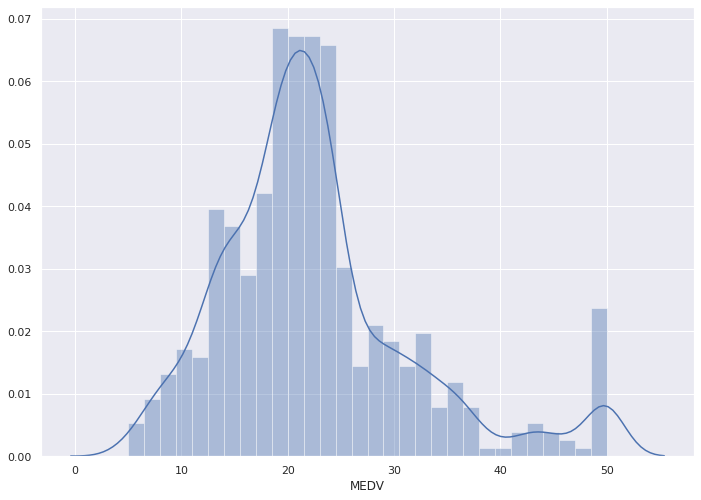

In [7]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.distplot(df['MEDV'], bins=30)
plt.show()

We see that the values of MEDV are distributed normally with few outliers.

Next, we can create a correlation matrix that measures the linear relationships between the variables. This correlation matrix can be formed by using the `corr` function from the pandas dataframe library. We will use the `heatmap` function from the seaborn library to plot the correlation matrix. This way, we can get an overview of features that seem correlated.

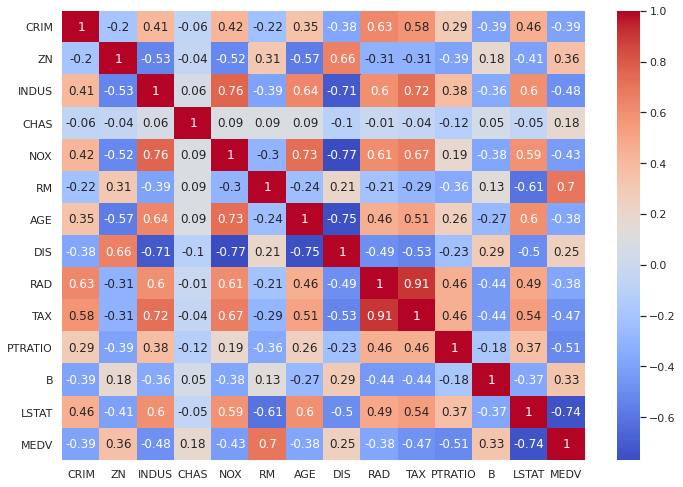

In [8]:
correlation_matrix = df.corr().round(2)
# annot = True to print the values inside the square
sns.heatmap(data=correlation_matrix, annot=True, cmap="coolwarm")

The correlation coefficient of these variables ranges from -1 to 1. If the value is close to 1 (dark red), it means that there is a strong positive correlation between the two variables. When it is close to -1 (dark blue), the variables have a strong negative correlation. Can you see the variables that seem to be strongly correlated with MEDV?

### Fitting a model: beware of multicolinearity

To fit a linear regression model, we select those features which have a high correlation with our target variable MEDV. By looking at the correlation matrix we can see that RM has a strong positive correlation with MEDV (0.7) where as LSTAT has a high negative correlation with MEDV(-0.74).

An important point in selecting features for a linear regression model is to check for *multicolinearity*. The features RAD, TAX have a correlation of 0.91: they are strongly correlated to each other. 

Consider the simplest case where 𝑌 is regressed against 𝑋 and 𝑍 and where 𝑋 and 𝑍 are highly positively correlated. Then the effect of 𝑋 on 𝑌 is hard to distinguish from the effect of 𝑍 on 𝑌 because any increase in 𝑋 tends to be associated with an increase in 𝑍.

In short, we should remove these features. The same goes for the features DIS and AGE which have a correlation of -0.75.

Based on the above observations we will RM and LSTAT as our features. Using a scatter plot, let’s see how these features vary with MEDV.

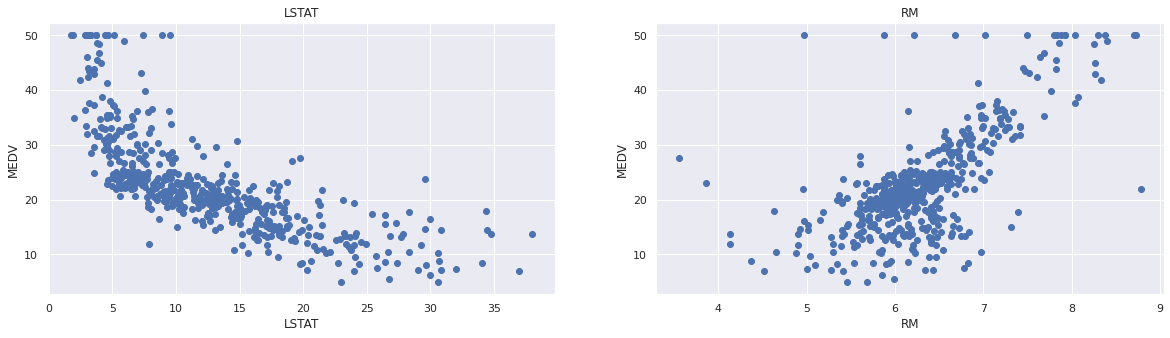

In [9]:
plt.figure(figsize=(20, 5))

features = ['LSTAT', 'RM']
target = df['MEDV']

for i, col in enumerate(features):
    plt.subplot(1, len(features) , i+1)
    x = df[col]
    y = target
    plt.scatter(x, y, marker='o')
    plt.title(col)
    plt.xlabel(col)
    plt.ylabel('MEDV')

The prices increase as the value of RM increases linearly. There are few outliers and the data seems to be capped at 50.
The prices tend to decrease with an increase in LSTAT. Though it doesn’t look to be following exactly a linear line.

### Splitting the data

Next, we split the data into training and testing sets. We train the model with 80% of the samples and test with the remaining 20%. We do this to assess the model’s performance on unseen data. To split the data we use `train_test_split` function provided by scikit-learn . We finally print the sizes of our training and test set to verify if the splitting has occurred properly.

In [10]:
# Defining independent (X) and dependent (Y) variables
X = df[['LSTAT','RM']]
Y = df["MEDV"]

In [11]:
# Defining split 
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state=5)
print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(404, 2)
(102, 2)
(404,)
(102,)


Let's fit the model

In [12]:
lm = LinearRegression()
model = lm.fit(X_train, Y_train)

And let's evaluate it using RMSE and R2-score. 

The **RMSE** is the square root of the variance of the residuals. It indicates the absolute fit of the model to the data: how close the observed data points are to the model's predicted values. 

The **R2** socre is the proportion of the variance in the dependent variable that is predictable from the independent variable(s).

In [13]:
# model evaluation for training set
y_train_predict = model.predict(X_train)
rmse = (np.sqrt(mean_squared_error(Y_train, y_train_predict)))
r2 = r2_score(Y_train, y_train_predict)

print("The model performance for training set")
print("--------------------------------------")
print('RMSE is {}'.format(rmse))
print('R2 score is {}'.format(r2))
print("\n")

# model evaluation for testing set
y_test_predict = model.predict(X_test)
rmse = (np.sqrt(mean_squared_error(Y_test, y_test_predict)))
r2 = r2_score(Y_test, y_test_predict)

print("The model performance for testing set")
print("--------------------------------------")
print('RMSE is {}'.format(rmse))
print('R2 score is {}'.format(r2))

The model performance for training set
--------------------------------------
RMSE is 5.6371293350711955
R2 score is 0.6300745149331701


The model performance for testing set
--------------------------------------
RMSE is 5.137400784702911
R2 score is 0.6628996975186952


In our case of multivariable linear regression, the regression model has to find the most optimal coefficients for all the attributes. Let's see what coefficients our regression model has chosen:

In [14]:
coeff_df = pd.DataFrame(lm.coef_, X.columns, columns=['Coefficient'])  
coeff_df

,Coefficient
LSTAT,-0.717230
RM,4.589388


And let's make some predictions.

In [15]:
y_predict = lm.predict(X)
print(y_predict[:5])

[29.33966548 25.64922478 32.82056043 32.74412501 31.71376526]


Finding the intercept and regression coeficient works as follows:

In [16]:
print('Intercept: \n', model.intercept_)
print('Coefficients: \n', model.coef_)

Intercept: 
 2.7362403426066066
Coefficients: 
 [-0.71722954  4.58938833]


Let's print the R² score of our model. This score provides a measure of how well observed outcomes are replicated by our model, based on the proportion of total variation of outcomes explained by the model.

In [17]:
lm.score(X,Y)

0.6364367726715208

### Using `statsmodels`

Let's make another model with `statsmodels`, just to see the difference. The nice thing about `statsmodels` is that it outputs a nice summary of the model, including metrics for model evaluation such as the R-squared value (a value ranging from 0 to 1 that indicates to what extent X perfectly accounts for all the variation in Y).

In [ ]:
model = sm.OLS(Y, X).fit()
predictions = model.predict(X) 

In [ ]:
print_model = model.summary()
print(print_model)

                            OLS Regression Results                            
Dep. Variable:                   MEDV   R-squared:                       0.948
Model:                            OLS   Adj. R-squared:                  0.948
Method:                 Least Squares   F-statistic:                     4637.
Date:                Mon, 05 Aug 2019   Prob (F-statistic):               0.00
Time:                        13:16:52   Log-Likelihood:                -1582.9
No. Observations:                 506   AIC:                             3170.
Df Residuals:                     504   BIC:                             3178.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
LSTAT         -0.6557      0.031    -21.458      0.0

## Regression on Reddit: Preprocessing

We'll start by cleaning up our data a bit. We'll use r/amitheasshole; see the Classification notebook from week 5-3 for more info. Let's load it up. First, make sure the .csv in the same folder as this notebook (you can find it in the Class Dropbox).

In [18]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [19]:
downloaded = drive.CreateFile({'id':"1OGjtSWvPKmDseWQuzWA2EfoX_41ohhGo"})   
downloaded.GetContentFile('amita-submissions.csv')

In [20]:
# load into df
df = pd.read_csv("amita-submissions.csv", lineterminator='\n', encoding="utf8")[:20000]

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (7,11) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [21]:
# clean up empty entries
df = df.drop(['augmented_at', 'augmented_count', 'distinguish'], axis=1)
df = df[~df['selftext'].isin(['[removed]', '[deleted]' ])].dropna(subset=['selftext'])
len(df)

16267

In [22]:
df.head()

,idint,idstr,created,self,nsfw,author,title,url,selftext,score,subreddit,textlen,num_comments,flair_text,flair_css_class
0,87247149,t3_1fy0bx,1370724175,1,0,flignir,AItA: I like air conditioning and my coworkers...,NaN,I work in an office that requires me to wear a...,2,AmItheAsshole,1067,1,not the asshole,not
1,118961390,t3_1ytr72,1393275159,1,0,Irishman_reddit,[AITA] Construction worker here,NaN,I have been on a parking structure project for...,63,AmItheAsshole,565,9,too close to call,NaN
2,118969807,t3_1ytxov,1393278651,1,0,Bobsmit,[AITA] I wrote an explanation in TIL and came ...,NaN,[Here is the post in question](http://www.redd...,51,AmItheAsshole,510,13,asshole,ass
3,118975728,t3_1yu29c,1393281184,1,0,WoopAhhh,[AITA] Threw my parent's donuts away,NaN,"My parents are diabetic, morbidly obese, and a...",142,AmItheAsshole,735,27,asshole,ass
4,118978034,t3_1yu41e,1393282238,1,0,ThisIsMeYoRightHere,[AITA] I Put My Empty Beer on a Bar Table,NaN,"Relevant Facts:\n\n1) It was a crowded bar, th...",46,AmItheAsshole,660,7,nothing happened,NaN


Let's look at our Y – which will be the score.

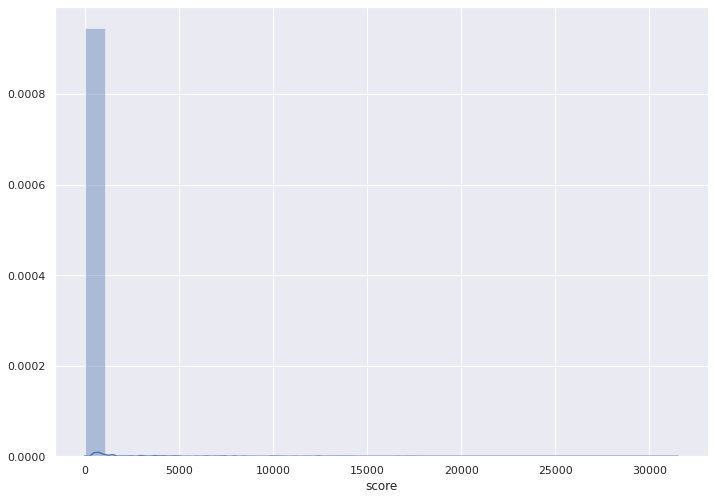

In [23]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.distplot(df['score'], bins=30)
plt.show()

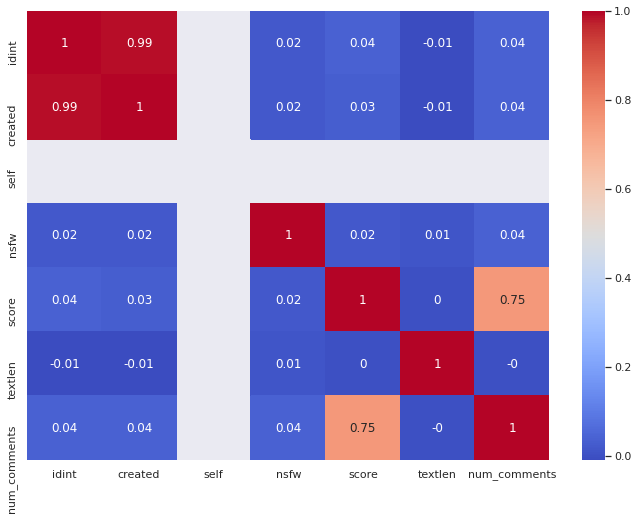

In [24]:
correlation_matrix = df.corr().round(2)
# annot = True to print the values inside the square
sns.heatmap(data=correlation_matrix, annot=True, cmap="coolwarm")

Looks like `score` and `num_comments` are related. This makes intuitive sense. Let's grab  both `num_comments` and `textlen` as our X in order to predict `score`.

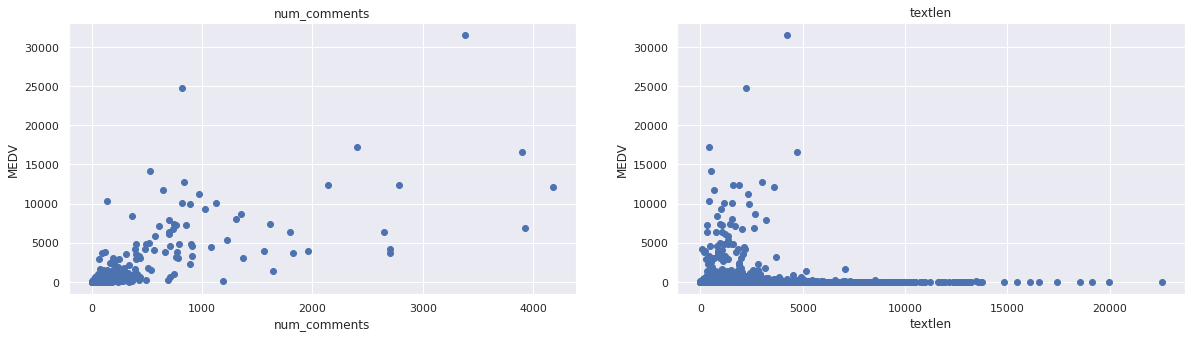

In [25]:
plt.figure(figsize=(20, 5))

features = ['num_comments', 'textlen']
target = df['score']

for i, col in enumerate(features):
    plt.subplot(1, len(features) , i+1)
    x = df[col]
    y = target
    plt.scatter(x, y, marker='o')
    plt.title(col)
    plt.xlabel(col)
    plt.ylabel('MEDV')

In [26]:
# define the data/predictors a X
X = df[['num_comments']]

# Put the target (housing value -- MEDV) in another DataFrame
Y = df[['score']]

In [27]:
# Defining split 
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state=5)
print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(13013, 1)
(3254, 1)
(13013, 1)
(3254, 1)


In [28]:
lm = LinearRegression()
model = lm.fit(X_train, Y_train)

And let's evaluate it using RMSE and R2-score. 

The **RMSE** is the square root of the variance of the residuals. It indicates the absolute fit of the model to the data: how close the observed data points are to the model's predicted values. 

The **R2** socre is the proportion of the variance in the dependent variable that is predictable from the independent variable(s).

In [29]:
# model evaluation for training set
y_train_predict = model.predict(X_train)
rmse = (np.sqrt(mean_squared_error(Y_train, y_train_predict)))
r2 = r2_score(Y_train, y_train_predict)

print("The model performance for training set")
print("--------------------------------------")
print('RMSE is {}'.format(rmse))
print('R2 score is {}'.format(r2))
print("\n")

# model evaluation for testing set
y_test_predict = model.predict(X_test)
rmse = (np.sqrt(mean_squared_error(Y_test, y_test_predict)))
r2 = r2_score(Y_test, y_test_predict)

print("The model performance for testing set")
print("--------------------------------------")
print('RMSE is {}'.format(rmse))
print('R2 score is {}'.format(r2))

The model performance for training set
--------------------------------------
RMSE is 392.839227658504
R2 score is 0.5512593232866039


The model performance for testing set
--------------------------------------
RMSE is 274.79711943663364
R2 score is 0.6698997721577419


In our case of multivariable linear regression, the regression model has to find the most optimal coefficients for all the attributes. Let's see what coefficients our regression model has chosen:

In [30]:
coeff_df = pd.DataFrame(lm.coef_, X.columns, columns=['Coefficient'])  
coeff_df

,Coefficient
num_comments,4.523345


And let's make some predictions:

In [31]:
y_predict = lm.predict(X)
print(y_predict[:5])

[[-48.23687993]
 [-12.0501189 ]
 [  6.04326162]
 [ 69.37009342]
 [-21.09680915]]


Finding the intercept and regression coeficient:

In [32]:
print('Intercept: \n', model.intercept_)
print('Coefficients: \n', model.coef_)

Intercept: 
 [-52.76022505]
Coefficients: 
 [[4.52334513]]


Let's print the R² score of our model. This score provides a measure of how well observed outcomes are replicated by our model, based on the proportion of total variation of outcomes explained by the model.

In [33]:
lm.score(X,Y)

0.5681811613875367

Let's see the output of `statsmodels` as well. For more info on how to interpret R-squared values, see https://blog.minitab.com/blog/adventures-in-statistics-2/regression-analysis-how-do-i-interpret-r-squared-and-assess-the-goodness-of-fit

In [34]:
model = sm.OLS(Y, X).fit()
predictions = model.predict(X) 

In [35]:
print_model = model.summary()
print(print_model)

                                 OLS Regression Results                                
Dep. Variable:                  score   R-squared (uncentered):                   0.567
Model:                            OLS   Adj. R-squared (uncentered):              0.567
Method:                 Least Squares   F-statistic:                          2.129e+04
Date:                Wed, 05 Aug 2020   Prob (F-statistic):                        0.00
Time:                        16:24:53   Log-Likelihood:                     -1.1948e+05
No. Observations:               16267   AIC:                                  2.390e+05
Df Residuals:                   16266   BIC:                                  2.390e+05
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                   coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------